In [12]:
! mamba install -qy fiona

  Package                         Version  Build               Channel                     Size
─────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────

  + blosc                          1.21.0  h9c3ff4c_0          conda-forge/linux-64      841 KB
  + fiona                          1.8.21  py39h83acdc4_1      conda-forge/linux-64      928 KB
  + gdal                            3.4.2  py39hc691d54_4      conda-forge/linux-64        2 MB
  + libllvm13                      13.0.1  hf817b99_2          conda-forge/linux-64       34 MB
  + munch                           2.5.0  py_0                conda-forge/noarch         12 KB

  Change:
─────────────────────────────────────────────────────────────────────────────────────────────────

  - boost-cpp                      1.74.0  h312852a_4          installed                       
  + boost-

In [16]:
import json
import os
from pathlib import Path
import subprocess

output: subprocess.CompletedProcess = subprocess.run(["mamba", "list", "^proj", "--json"], capture_output=True)
proj_dist_name: str = json.loads(output.stdout)[0]["dist_name"]
os.environ["PROJ_LIB"]=f"/opt/conda/pkgs/proj-{proj_dist_name}"

In [17]:
import fiona
from google.cloud.storage import Blob, Bucket, Client

In [18]:
gcp_project: str = "global-water-watch"
gcp_bucket: str = "global-water-watch"

os.environ["GCLOUD_PROJECT"] = "global-water-watch"

out_dir: Path = Path.cwd() / "output"

In [19]:
client: Client = Client()
bucket: Bucket = Bucket(client, name=gcp_bucket, user_project=gcp_project)

In [20]:
reservoir_dir: Path = out_dir / "reservoirs"
blob: Blob = client.list_blobs(bucket, prefix="shp/reservoirs-v1.0")
for b in blob:
    b.download_to_filename(reservoir_dir / b.name.split("/")[-1])

In [98]:
shapes = fiona.open(reservoir_dir / "reservoirs-v1.0.shp")

In [100]:
a = {}
a.update({"a": 1})

In [102]:
from functools import reduce

def process_shapes(collection: dict, shape: dict):
    fid: int = int(shape["properties"]["fid"])
    s_type: str = shape["geometry"]["type"]
    coords: List = shape["geometry"]["coordinates"]
    if s_type == "MultiPolygon":
        collection.update({fid: MultiPolygon([Polygon(c[0]) for c in coords])})
    elif s_type == "Polygon":
        collection.update({fid: Polygon(coords[0])})
    return collection

p_shapes = reduce(process_shapes, iter(shapes), {})

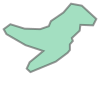

In [114]:
p_shapes[60000]